In [96]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sobhanmoosavi_us_accidents_path = kagglehub.dataset_download('sobhanmoosavi/us-accidents')

print('Data source import complete.')


Data source import complete.


In [97]:
# This Python 3 environment comes witha many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-accidents/US_Accidents_March23.csv


In [98]:
sobhanmoosavi_us_accidents_path

'/kaggle/input/us-accidents'

In [99]:
import os
file_path = f"{sobhanmoosavi_us_accidents_path}/{os.listdir(sobhanmoosavi_us_accidents_path)[0]}"
file_path

'/kaggle/input/us-accidents/US_Accidents_March23.csv'

In [100]:
pd.read_csv(file_path, nrows=100)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,A-96,Source2,2,2016-02-11 07:28:16,2016-02-11 07:58:16,39.994061,-82.729416,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
96,A-97,Source2,3,2016-02-11 07:29:06,2016-02-11 08:18:10,41.355396,-81.819267,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
97,A-98,Source2,2,2016-02-11 07:53:55,2016-02-11 08:23:55,39.687389,-84.237968,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
98,A-99,Source2,2,2016-02-11 08:07:02,2016-02-11 08:37:02,39.751038,-84.214325,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [ ]:
important_cols = [
    # Accident severity and time
    "Severity",
    "Start_Time", "End_Time", "Timezone", "Start_Lat", "Start_Lng",

    # Location details
    "City", "County", "State",

    # Weather-related
    "Temperature(F)", "Humidity(%)", "Visibility(mi)",
    "Wind_Speed(mph)", "Precipitation(in)", "Weather_Condition",
    "Weather_Timestamp", "Sunrise_Sunset",

    # Road details
    "Distance(mi)", "Street", "Zipcode",
    "Amenity", "Bump", "Crossing", "Junction", "Railway",
    "Roundabout", "Station", "Stop", "Traffic_Calming",
    "Traffic_Signal", "Turning_Loop"
]


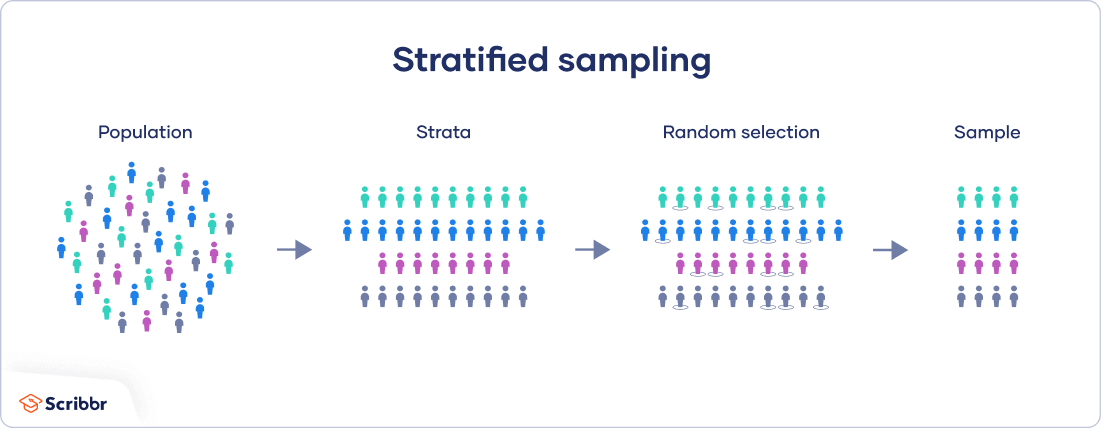

In [102]:
# Parameters
chunksize = 100_000   # read in chunks to save memory
target_rows = 200_000 # total sample size

sample_list = []

In [103]:
# ======== Pass 1: ]Distribution over Severity ========
severity_counts = {}
total_rows = 0

for chunk in pd.read_csv(file_path, usecols=["Severity"], chunksize=chunksize):
    counts = chunk["Severity"].value_counts()
    for sev, cnt in counts.items():
        severity_counts[sev] = severity_counts.get(sev, 0) + cnt
    total_rows += len(chunk)

In [104]:
severity_target = {
    sev: int((count / total_rows) * target_rows)
    for sev, count in severity_counts.items()
}

In [105]:
final_sample = []
taken_counts = {sev: 0 for sev in severity_target}

In [106]:
import random

for chunk in pd.read_csv(file_path, usecols=important_cols, chunksize=chunksize):
    # Shuffle the rows in the chunk with random seed
    chunk = chunk.sample(frac=1, random_state=random.randint(0, 1_000_000))

    for sev in severity_target:
        needed = severity_target[sev] - taken_counts[sev]
        if needed > 0:
            sev_rows = chunk[chunk["Severity"] == sev]
            if len(sev_rows) > needed:
                sev_rows = sev_rows.sample(
                    n=needed,
                    random_state=random.randint(0, 1_000_000)
                )
            final_sample.append(sev_rows)
            taken_counts[sev] += len(sev_rows)


In [108]:
final_sample = pd.concat(final_sample)

In [109]:
final_sample.to_csv("us_accidents_stratified_sample.csv", index=False)

In [110]:
final_sample.head()

,Severity,Start_Time,End_Time,Distance(mi),Street,City,County,State,Zipcode,Timezone,...,Crossing,Junction,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
93123,2,2016-08-28 12:09:36,2016-08-28 12:54:36,0.00,Riverside Fwy E,Corona,Riverside,CA,92879,US/Pacific,...,False,False,False,False,False,False,False,False,False,Day
18537,2,2016-11-24 02:34:11,2016-11-24 03:18:50,0.01,Cabrillo Hwy S,Half Moon Bay,San Mateo,CA,94019,US/Pacific,...,False,False,False,False,False,False,False,False,False,Night
39278,2,2016-05-20 15:26:30,2016-05-20 15:56:30,0.00,John Muir Pkwy,Rodeo,Contra Costa,CA,94572,US/Pacific,...,False,False,False,False,False,False,False,False,False,Day
93398,2,2016-08-29 14:37:43,2016-08-29 15:22:43,0.00,Artesia Fwy W,Bellflower,Los Angeles,CA,90706,US/Pacific,...,False,True,False,False,False,False,False,False,False,Day
15582,2,2016-11-07 19:15:43,2016-11-07 19:45:43,0.01,CA-242 N,Concord,Contra Costa,CA,94520,US/Pacific,...,False,False,False,False,False,False,False,False,False,Night
